In [ ]:
# На случай, если нет необходимых пакетов
!pip install topicnet
!pip install bigartm
!pip install pymorphy2

In [2]:
# BigARTM, необходим для работы TopicNet
import artm

# Визуализация, работа с данными
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Установка графиков по умолчанию
sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

from IPython.display import display, display_html

# for preprocessing
import nltk

from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from nltk.corpus import (
    stopwords,
    wordnet,
)

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger_ru")
nltk.download("stopwords")

from nltk.stem import WordNetLemmatizer

from pymorphy2 import MorphAnalyzer

from collections import Counter

# Для отображения процесса
from tqdm import tqdm

from topicnet.cooking_machine.model_constructor import (
    create_default_topics,
    count_vocab_size,
    init_model,
)

from topicnet.cooking_machine.rel_toolbox_lite import (
    count_vocab_size,
    modality_weight_rel2abs,
)

from typing import Dict, List

# Возможно использование для подсчёта времени
from time import process_time

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загружаем [данные](https://disk.yandex.ru/d/DAdhmVB2eFkdBQ) с мая по август 2008 года.

In [3]:
# С учётом особенности хранения данных в Kaggle
# %cp /kaggle/input/lenta-mid-2008/lenta_2008_may_aug_preprocessed.csv .
lenta_data = Dataset("/kaggle/working/lenta_2008_may_aug_preprocessed.csv")

/opt/conda/lib/python3.7/site-packages/topicnet/cooking_machine/dataset.py:220: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





Необходимо регулировать случайность, поэтому заведём возможность обновлять параметр `seed`, отвечающий за случайность

In [4]:
def init_simple_default_model_with_seed(
    dataset: Dataset,
    modalities_to_use: List[str] or Dict[str, float],
    main_modality: str,
    specific_topics: List[str] or int,
    background_topics: List[str] or int,
    seed: int = -1,
) -> artm.ARTM:
    """
    Инициализация стандартной модели BigARTM с учётом случайности.
    Возвращает тематическую модель формата artm.ARTM
    param dataset: данные в формате Dataset
    param modalities_to_use: используемые модальности
    param main_modality: основная модальность
    param specific_topics: предметные темы
    param background_topics: фоновые темы
    param seed: параметр, отвечающий за случайность
    """

    # инициализация весов
    if isinstance(modalities_to_use, dict):
        modalities_weights = modalities_to_use
    else:
        modalities_weights = {class_id: 1 for class_id in modalities_to_use}

    # создание имён тем
    specific_topic_names, background_topic_names = create_default_topics(
        specific_topics, background_topics
    )
    dictionary = dataset.get_dictionary()

    # получение данных о токенах
    tokens_data = count_vocab_size(dictionary, modalities_to_use)
    abs_weights = modality_weight_rel2abs(
        tokens_data, modalities_weights, main_modality
    )

    # инициализация модели
    model = init_model(
        topic_names=specific_topic_names + background_topic_names,
        class_ids=abs_weights,
    )

    # добавление регуляризаторов для фоновых тем
    if len(background_topic_names) > 0:
        model.regularizers.add(
            artm.SmoothSparsePhiRegularizer(
                name="smooth_phi_bcg",
                topic_names=background_topic_names,
                tau=0.0,
                class_ids=[main_modality],
            ),
        )
        model.regularizers.add(
            artm.SmoothSparseThetaRegularizer(
                name="smooth_theta_bcg",
                topic_names=background_topic_names,
                tau=0.0,
            ),
        )

    # задаём зерно случайности
    model.seed = seed
    model.initialize(dictionary)
    add_standard_scores(
        model, main_modality=main_modality, all_modalities=modalities_to_use
    )

    return model

С помощью тематического моделирования выделим $150$ тем.

Модальности:
- Слова, приведённые в начальную форму
- Биграммы (словосочетания из двух слов, например: тематическая модель)

Основной модальностью будут биграммы, так как биграммы лучше отражают содержание новости, чем отдельные слова. Однако слов намного больше, чем биграмм.

In [5]:
TOTAL_TOPICS = 150  # количество тем

# задаём модель M_0
model_0 = init_simple_default_model_with_seed(
    dataset=lenta_data,
    modalities_to_use={"@lemmatized": 1.2, "@bigram": 1.0},
    main_modality="@bigram",
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
    seed=1,
)

# приводим в формат TopicNet
tm_0 = TopicModel(model_0)

Посмотрим, что будет после обучения за $5$ итераций.

In [6]:
ITER_NUM = 5

for _ in tqdm(range(ITER_NUM)):
    tm_0._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


Смотрим, как представлены темы.

In [7]:
model_0_top_tok = TopTokensViewer(tm_0, num_top_tokens=5, method="phi")
model_0_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.051670 
 
 
 объединить_арабский 
 0.047350 
 
 
 олег_митволя 
 0.044150 
 
 
 ураган_наргиса 
 0.028560 
 
 
 забайкальский_край 
 0.024040 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.017840 
 
 
 который 
 0.012390 
 
 
 митволя 
 0.010070 
 
 
 свой 
 0.008670 
 
 
 росприроднадзор 
 0.008130 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 главный_тренер 
 0.048710 
 
 
 нобелевский_премия 
 0.036920 
 
 
 егор_титов 
 0.035240 
 
 
 inglorious_bastards 
 0.032030 
 
 
 станислав_черчёс 
 0.025040 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.017560 
 
 
 спартак 
 0.016760 
 
 
 который 
 0.011810 
 
 
 фильм 
 0.010120 
 
 
 титов 
 0.009190 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 моральный_ущерб 
 0.047790 
 
 
 лишение_свобода 
 0.035940 
 
 
 компенсация_моральный 
 0.028570 
 
 
 атомный_энергетика 
 0.026900 
 
 
 избирательный_кампания 
 0.026740 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.018880 
 
 
 который 
 0.014030 
 
 
 тысяча 
 0.007530 
 
 
 свой 
 0.007300 
 
 
 иск 
 0.007220 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.091110 
 
 
 премьер_министр 
 0.058670 
 
 
 бин_ладен 
 0.051130 
 
 
 экономический_санкция 
 0.040440 
 
 
 тони_блэр 
 0.027330 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.019700 
 
 
 браун 
 0.012130 
 
 
 великобритания 
 0.011220 
 
 
 ядерный 
 0.010950 
 
 
 сша 
 0.010460 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.045300 
 
 
 ракетка_мир 
 0.036740 
 
 
 мария_шарапов 
 0.026080 
 
 
 елена_дементьев 
 0.023780 
 
 
 теннисный_турнир 
 0.023380 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.020930 
 
 
 первый 
 0.014930 
 
 
 матч 
 0.014400 
 
 
 счёт 
 0.011370 
 
 
 сафин 
 0.011140 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.112820 
 
 
 new_york 
 0.097710 
 
 
 природный_ресурс 
 0.037790 
 
 
 royal_dutch 
 0.034520 
 
 
 dutch_shell 
 0.033750 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.013910 
 
 
 times 
 0.012050 
 
 
 который 
 0.011940 
 
 
 york 
 0.009980 
 
 
 доллар 
 0.009330 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.140880 
 
 
 сей_пора 
 0.092410 
 
 
 архиерейский_собор 
 0.045510 
 
 
 епископ_диомид 
 0.032930 
 
 
 храм_христос 
 0.023090 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.014500 
 
 
 диомид 
 0.010080 
 
 
 принимать 
 0.009410 
 
 
 человек 
 0.009160 
 
 
 сей 
 0.008730 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.057910 
 
 
 bear_stearns 
 0.041640 
 
 
 ростов_дон 
 0.035270 
 
 
 исправительный_учреждение 
 0.033470 
 
 
 риана_недвижимость 
 0.033020 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.021340 
 
 
 строительство 
 0.010200 
 
 
 который 
 0.008260 
 
 
 тысяча 
 0.007940 
 
 
 посёлок 
 0.007090 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.083880 
 
 
 владимир_потанин 
 0.065020 
 
 
 собрание_акционер 
 0.053340 
 
 
 полюс_золото 
 0.031080 
 
 
 годовой_собрание 
 0.029000 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.022600 
 
 
 процент 
 0.017580 
 
 
 норникель 
 0.014380 
 
 
 акция 
 0.014140 
 
 
 прохоров 
 0.013970 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 страсбургский_суд 
 0.050580 
 
 
 роман_абрамо

Пользователь проводит исследование на спортивную тематику, в связи с чем релевантными он считает темы, так или иначе связанные со спортом.

Релевантные:
- $4$ (теннис)
- $59$ (хоккей)
- $69$ (турниры, напрример: Кубок Стэнли)
- $128$ (футбол, в частности Кубок УЕФА и чемпионат России по футболу)
- $132$ (баскетбол)
- $146$ (Лига чемпионов, финал 2008 в Лужниках между «Челси» и «Манчестер Юнайтед»)

Нерелевантные:
- $137$ (Лига чемпионов + олимпиада в Пекине, _в дальнейшем это удастся разделить_)

Все остальные были признаны мусорными по мнению пользователя.

Далее нам необходима работа со словарём, чтобы использовать регуляризатор сглаживания для фиксации тем.

In [8]:
def _get_dict_line_for_topic(
    dict_line: str,
    topic_col,
) -> str:
    """
    Возращает данные из словаря по теме.
    """
    dict_items = dict_line.split(", ")
    token, modality = dict_items[:2]
    dict_items[2] = str(topic_col[modality][token])

    return ", ".join(dict_items)

Запоминаем словарь.

In [9]:
lenta_data.get_dictionary().save_text("dict.txt")
dict_lines = open("dict.txt").readlines()

Пишем словарь для релевантных тем.

In [10]:
relevant_0 = ["topic_4", "topic_59", "topic_69", "topic_128", "topic_132", "topic_146"]

for topic_name in relevant_0:
    topic_col = tm_0.get_phi().loc[:, topic_name]
    topic_dict_lines = dict_lines[:2]

    for l in tqdm(dict_lines[2:], total=len(dict_lines[2:])):
        topic_dict_lines.append(_get_dict_line_for_topic(l, topic_col))

    with open(f"dict_{topic_name}.txt", "w") as f:
        f.writelines(topic_dict_lines)

100%|██████████| 79491/79491 [15:02<00:00, 88.11it/s] 


Клонируем тему.

In [11]:
tm_1 = TopicModel.clone(tm_0)

Для фиксации потребуется довольно большой коэффициент, например, ${10}^{10}$

In [12]:
TAU_PRESERVE = 10**10  # используем большой коэффициент для сохранения релевантных тем

Заводим регуляризаторы сглаживания с целью фиксации тем.

In [13]:
dictionaries = []

for topic_name in relevant_0:
    dictionary = artm.Dictionary()
    dictionary.load_text(f"dict_{topic_name}.txt")
    dictionaries.append(dictionary)

    # добавляем регуляризатор сглаживания для фиксации текущей темы
    tm_1._model.regularizers.add(
        artm.regularizers.SmoothSparsePhiRegularizer(
            name=f"preserve_relevant_{topic_name}",
            tau=TAU_PRESERVE,
            class_ids=["@bigram", "@lemmatized"],
            topic_names=[topic_name],
            dictionary=dictionary,
        )
    )

Так как тематические модели неустойчивы, и результат моделирования зависит от случайности, то изменяем параметр `seed`.

In [14]:
tm_1._model.seed = 2
tm_1._model.seed

2

Далее нужно декоррелировать «мусорные» темы с релевантными темами. Для этого вспомним про параметр `topic_pairs`, который отвечает за коэффициент декоррелирования для каждой пары. Установим коэффициенты по следующему принципу.

- Пусть $i$, $j$ — номера рассматриваемых тем.
- Если темы $i$ и $j$ релевантные, то коэффициент декоррелирования равен нулю.
- Если одна из тем релевантная, а другая является «мусорной», то коэффициент декоррелирования равен $1$.
- Если темы $i$ и $j$ «мусорные», то коэффициент декоррелирования равен $0$.

In [15]:
# нерелевантные темы
irrelevant_0 = ["topic_137"]

# мусорные темы
garbage_topics_0 = []
for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in relevant_0 and topic_name not in irrelevant_0:
        garbage_topics_0.append(topic_name)

# релевантые и мусорные темы вместе
margin_topics_0 = []
margin_topics_0.extend(relevant_0)
margin_topics_0.extend(garbage_topics_0)

# словарь попарных коэффициентов декорреляции
decorrelating_pairs_0 = dict([])

# релевантные темы
for topic1 in tqdm(relevant_0):
    current_weights = dict([])
    for topic2 in relevant_0:
        current_weights[topic2] = 0.0
    for topic2 in garbage_topics_0:
        current_weights[topic2] = 1.0
    decorrelating_pairs_0[topic1] = current_weights

# мусорные темы
for topic1 in tqdm(garbage_topics_0):
    current_weights = dict([])
    for topic2 in relevant_0:
        current_weights[topic2] = 1.0
    for topic2 in garbage_topics_0:
        current_weights[topic2] = 0.0
    decorrelating_pairs_0[topic1] = current_weights

# пробуем topic_pairs с указанием коэффициентов
tm_1._model.regularizers.add(
    artm.regularizers.DecorrelatorPhiRegularizer(
        name="decorrelate_garbage_topics",
        tau=10000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=margin_topics_0,
        topic_pairs=decorrelating_pairs_0,
    ),
    overwrite=True,
)

100%|██████████| 143/143 [00:00<00:00, 42589.33it/s]


Далее обучаем модель $M_1$ за $5$ итераций. Обратим внимание, что одна итерация длится в несколько раз дольше вследствие применения регуляризатора декоррелирования релевантных тем с «мусорными».

In [16]:
for _ in tqdm(range(ITER_NUM)):
    tm_1._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [04:12<00:00, 50.60s/it]


Смотрим на изменения.

In [17]:
model_1_top_tok = TopTokensViewer(tm_1, num_top_tokens=5, method="phi")
model_1_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.398920 
 
 
 объединить_арабский 
 0.149740 
 
 
 олег_митволя 
 0.082590 
 
 
 ураган_наргиса 
 0.015240 
 
 
 забайкальский_край 
 0.012950 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014450 
 
 
 митволя 
 0.013840 
 
 
 росприроднадзор 
 0.011140 
 
 
 арабский 
 0.010240 
 
 
 новый 
 0.007470 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.165390 
 
 
 егор_титов 
 0.050750 
 
 
 inglorious_bastards 
 0.039820 
 
 
 брэд_питта 
 0.031830 
 
 
 лауреат_нобелевский 
 0.028810 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 спартак 
 0.022320 
 
 
 год 
 0.016660 
 
 
 титов 
 0.011950 
 
 
 тарантино 
 0.010840 
 
 
 нобелевский 
 0.010140 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 моральный_ущерб 
 0.168290 
 
 
 судебный_разбирательство 
 0.103190 
 
 
 генеральный_прокурор 
 0.065250 
 
 
 компенсация_моральный 
 0.026550 
 
 
 юрий_чайка 
 0.024140 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.045210 
 
 
 иск 
 0.034370 
 
 
 год 
 0.019260 
 
 
 компенсация 
 0.018400 
 
 
 тысяча 
 0.012920 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.648260 
 
 
 бин_ладен 
 0.044730 
 
 
 экономический_санкция 
 0.018380 
 
 
 внешний_политика 
 0.013930 
 
 
 осама_бин 
 0.013340 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.039080 
 
 
 ядерный 
 0.015160 
 
 
 браун 
 0.014790 
 
 
 великобритания 
 0.014320 
 
 
 иранский 
 0.010520 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.045300 
 
 
 ракетка_мир 
 0.036740 
 
 
 мария_шарапов 
 0.026080 
 
 
 елена_дементьев 
 0.023780 
 
 
 теннисный_турнир 
 0.023380 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.020930 
 
 
 первый 
 0.014930 
 
 
 матч 
 0.014400 
 
 
 счёт 
 0.011370 
 
 
 сафин 
 0.011140 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.915960 
 
 
 new_york 
 0.027230 
 
 
 природный_ресурс 
 0.008780 
 
 
 royal_dutch 
 0.004370 
 
 
 dutch_shell 
 0.004030 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.015680 
 
 
 год 
 0.013190 
 
 
 природный 
 0.012090 
 
 
 shell 
 0.011890 
 
 
 тысяча 
 0.011890 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.788600 
 
 
 сей_пора 
 0.103520 
 
 
 архиерейский_собор 
 0.008150 
 
 
 епископ_диомид 
 0.005770 
 
 
 склад_боеприпас 
 0.004450 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.043340 
 
 
 пора 
 0.042870 
 
 
 сей 
 0.035000 
 
 
 участие 
 0.031260 
 
 
 который 
 0.013530 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.362790 
 
 
 ростов_дон 
 0.051670 
 
 
 риана_недвижимость 
 0.044180 
 
 
 bear_stearns 
 0.037310 
 
 
 административный_округ 
 0.030080 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.022940 
 
 
 объект 
 0.013160 
 
 
 сочи 
 0.010640 
 
 
 строительство 
 0.010080 
 
 
 город 
 0.007800 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.581110 
 
 
 владимир_потанин 
 0.058810 
 
 
 михаил_прохоров 
 0.036690 
 
 
 собрание_акционер 
 0.035260 
 
 
 олег_дерипаск 
 0.017140 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.041850 
 
 
 акция 
 0.022320 
 
 
 процент 
 0.017990 
 
 
 норникель 
 0.015840 
 
 
 прохоров 
 0.015370 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гей_парад 
 0.209670 
 
 
 роман_

Выделили одну новую релевантную тему: 63 (про бокс, Николая Валуева, бывший на тот момент депутатом от Кемеровской области). Все прежние релевантные темы сохранились. Более того, коэффициенты, связанные с токенами, практически не изменились.
Запоминаем словарь, связанный с этой темой.

In [18]:
relevant_1 = ["topic_63"]  # новые релевантные темы

for topic_name in relevant_1:
    topic_col = tm_1.get_phi().loc[:, topic_name]
    topic_dict_lines = dict_lines[:2]

    for l in tqdm(dict_lines[2:], total=len(dict_lines[2:])):
        topic_dict_lines.append(_get_dict_line_for_topic(l, topic_col))

    with open(f"dict_{topic_name}.txt", "w") as f:
        f.writelines(topic_dict_lines)

100%|██████████| 79491/79491 [22:19<00:00, 59.32it/s]


Далее создаём $M_2$ путём клонирования из $M_1$. Как и ранее, меняем параметр `seed` и применяем регуляризатор сглаживания.

In [19]:
# клонируем модель
tm_2 = TopicModel.clone(tm_1)
tm_2._model.seed = 3

# добавляем новый регуляризатор сглаживания
for topic_name in relevant_1:
    dictionary = artm.Dictionary()
    dictionary.load_text(f"dict_{topic_name}.txt")
    dictionaries.append(dictionary)

    tm_2._model.regularizers.add(
        artm.regularizers.SmoothSparsePhiRegularizer(
            name=f"preserve_relevant_{topic_name}",
            tau=TAU_PRESERVE,
            class_ids=["@bigram", "@lemmatized"],
            topic_names=[topic_name],
            dictionary=dictionary,
        )
    )

Далее повторяем те же шаги, что и ранее с моделью $M_1$.

In [20]:
# текущий список релевантных тем
current_relevant = []
current_relevant.extend(relevant_0)
current_relevant.extend(relevant_1)

# текущий список мусорных тем
garbage_topics_1 = []
for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in current_relevant and topic_name not in irrelevant_0:
        garbage_topics_1.append(topic_name)

# текущий список релевантных и мусорных тем вместе
margin_topics_1 = []
margin_topics_1.extend(current_relevant)
margin_topics_1.extend(garbage_topics_1)

# инициализируем список пар
decorrelating_pairs_1 = dict([])

# проходимся по релевантным темам
for topic1 in tqdm(current_relevant):
    current_weights = dict([])
    for topic2 in current_relevant:
        current_weights[topic2] = 0.0
    for topic2 in garbage_topics_1:
        current_weights[topic2] = 1.0
    decorrelating_pairs_1[topic1] = current_weights

# проходимся по мусорным темам
for topic1 in tqdm(garbage_topics_1):
    current_weights = dict([])
    for topic2 in current_relevant:
        current_weights[topic2] = 1.0
    for topic2 in garbage_topics_1:
        current_weights[topic2] = 0.0
    decorrelating_pairs_1[topic1] = current_weights

# пробуем topic_pairs с указанием коэффициентов
tm_2._model.regularizers.add(
    artm.regularizers.DecorrelatorPhiRegularizer(
        name="decorrelate_garbage_topics",
        tau=10000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=margin_topics_1,
        topic_pairs=decorrelating_pairs_1,
    ),
    overwrite=True,
)

100%|██████████| 142/142 [00:00<00:00, 45821.75it/s]


Дообучаем ещё на $5$ итераций.

In [21]:
for _ in tqdm(range(ITER_NUM)):
    tm_2._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [04:22<00:00, 52.55s/it]


Смотрим, что происходит с темами.

In [22]:
model_2_top_tok = TopTokensViewer(tm_2, num_top_tokens=5, method="phi")
model_2_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.942410 
 
 
 объединить_арабский 
 0.003560 
 
 
 олег_митволя 
 0.003340 
 
 
 забайкальский_край 
 0.001940 
 
 
 росприроднадзор_олег 
 0.001720 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 митволя 
 0.013360 
 
 
 арабский 
 0.012050 
 
 
 год 
 0.011640 
 
 
 росприроднадзор 
 0.011520 
 
 
 новый 
 0.007990 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.835510 
 
 
 крайний_мера 
 0.006470 
 
 
 егор_титов 
 0.005240 
 
 
 уходить_отставка 
 0.005000 
 
 
 inglorious_bastards 
 0.004750 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.020910 
 
 
 спартак 
 0.015230 
 
 
 актёр 
 0.009360 
 
 
 который 
 0.009350 
 
 
 титов 
 0.008830 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 моральный_ущерб 
 0.561480 
 
 
 судебный_разбирательство 
 0.052420 
 
 
 генеральный_прокурор 
 0.022540 
 
 
 удовлетворить_иск 
 0.017510 
 
 
 атомный_электростанция 
 0.010870 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.165600 
 
 
 иск 
 0.042800 
 
 
 подать 
 0.021800 
 
 
 год 
 0.015470 
 
 
 компенсация 
 0.014520 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.891100 
 
 
 бин_ладен 
 0.012330 
 
 
 экономический_санкция 
 0.005950 
 
 
 осама_бин 
 0.004820 
 
 
 лейбористский_партия 
 0.004730 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.047280 
 
 
 ядерный 
 0.017240 
 
 
 браун 
 0.015140 
 
 
 иранский 
 0.013830 
 
 
 великобритания 
 0.013720 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.045300 
 
 
 ракетка_мир 
 0.036740 
 
 
 мария_шарапов 
 0.026080 
 
 
 елена_дементьев 
 0.023780 
 
 
 теннисный_турнир 
 0.023380 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.020930 
 
 
 первый 
 0.014930 
 
 
 матч 
 0.014400 
 
 
 счёт 
 0.011370 
 
 
 сафин 
 0.011140 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.981690 
 
 
 природный_ресурс 
 0.004650 
 
 
 призовой_фонд 
 0.001410 
 
 
 де_жанейро 
 0.001290 
 
 
 рио_де 
 0.001290 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.023350 
 
 
 тысяча 
 0.017990 
 
 
 природный 
 0.017700 
 
 
 ресурс 
 0.014140 
 
 
 год 
 0.010490 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.904190 
 
 
 сей_пора 
 0.008050 
 
 
 православный_церковь 
 0.007580 
 
 
 архиерейский_собор 
 0.005800 
 
 
 русский_православный 
 0.005480 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.067390 
 
 
 пора 
 0.055530 
 
 
 участие 
 0.045120 
 
 
 сей 
 0.028770 
 
 
 церковь 
 0.010330 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.904970 
 
 
 ростов_дон 
 0.005300 
 
 
 риана_недвижимость 
 0.005210 
 
 
 административный_округ 
 0.004790 
 
 
 bear_stearns 
 0.004410 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.021180 
 
 
 объект 
 0.017150 
 
 
 сочи 
 0.012600 
 
 
 город 
 0.010270 
 
 
 строительство 
 0.008340 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.887710 
 
 
 собрание_акционер 
 0.008730 
 
 
 владимир_потанин 
 0.008640 
 
 
 михаил_прохоров 
 0.008640 
 
 
 олег_дерипаск 
 0.006990 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.040440 
 
 
 директор 
 0.030900 
 
 
 совет 
 0.028630 
 
 
 акционер 
 0.020550 
 
 
 акция 
 0.019500 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гей_парад 
 0.77

Из нерелевантных в релевантные переходит тема $137$. Теперь она больше посвящена Олимпиаде в Пекине, а упоминание про Лигу Чемпионов ушло из топ-5 токенов. Ранее найденные релевантные темы по-прежнему сохранились. Записываем это.

In [23]:
relevant_2 = ["topic_137"]
current_relevant.extend(relevant_2)

for topic_name in relevant_2:
    topic_col = tm_2.get_phi().loc[:, topic_name]
    topic_dict_lines = dict_lines[:2]

    for l in tqdm(dict_lines[2:], total=len(dict_lines[2:])):
        topic_dict_lines.append(_get_dict_line_for_topic(l, topic_col))

    with open(f"dict_{topic_name}.txt", "w") as f:
        f.writelines(topic_dict_lines)

100%|██████████| 79491/79491 [25:58<00:00, 51.00it/s]


Создаём модель $M_3$ путём клонирования, меняем параметр `seed`.

In [24]:
tm_3 = TopicModel.clone(tm_2)
tm_3._model.seed = 4

# добавляем регуляризатор
for topic_name in relevant_2:
    dictionary = artm.Dictionary()
    dictionary.load_text(f"dict_{topic_name}.txt")
    dictionaries.append(dictionary)

    tm_3._model.regularizers.add(
        artm.regularizers.SmoothSparsePhiRegularizer(
            name=f"preserve_relevant_{topic_name}",
            tau=TAU_PRESERVE,
            class_ids=["@bigram", "@lemmatized"],
            topic_names=[topic_name],
            dictionary=dictionary,
        )
    )

Далее обновляем регуляризатор декоррелирования «мусорных» тем с релевантными.

In [25]:
# нерелевантных тем больше нет
garbage_topics_2 = []
for i in tqdm(range(TOTAL_TOPICS)):
    topic_name = f"topic_{i}"
    if topic_name not in current_relevant:
        garbage_topics_2.append(topic_name)

# записываем релевантные и мусорные темы
margin_topics_2 = []
margin_topics_2.extend(current_relevant)
margin_topics_2.extend(garbage_topics_2)

# инициализируем
decorrelating_pairs_2 = dict([])

# проходимся по релевантным темам
for topic1 in tqdm(current_relevant):
    current_weights = dict([])
    for topic2 in current_relevant:
        current_weights[topic2] = 0.0
    for topic2 in garbage_topics_2:
        current_weights[topic2] = 1.0
    decorrelating_pairs_2[topic1] = current_weights

# проходимся по мусорным темам
for topic1 in tqdm(garbage_topics_2):
    current_weights = dict([])
    for topic2 in current_relevant:
        current_weights[topic2] = 1.0
    for topic2 in garbage_topics_2:
        current_weights[topic2] = 0.0
    decorrelating_pairs_2[topic1] = current_weights

# пробуем topic_pairs с указанием коэффициентов
tm_3._model.regularizers.add(
    artm.regularizers.DecorrelatorPhiRegularizer(
        name="decorrelate_garbage_topics",
        tau=10000,
        class_ids=["@bigram", "@lemmatized"],
        topic_names=margin_topics_2,
        topic_pairs=decorrelating_pairs_2,
    ),
    overwrite=True,
)

100%|██████████| 142/142 [00:00<00:00, 42780.58it/s]


Дообучаем ещё на $5$ итераций.

In [26]:
for _ in tqdm(range(ITER_NUM)):
    tm_3._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [04:38<00:00, 55.62s/it]


Смотрим, что изменилось в этот раз.

In [27]:
model_3_top_tok = TopTokensViewer(tm_3, num_top_tokens=5, method="phi")
model_3_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.950630 
 
 
 объединить_арабский 
 0.003480 
 
 
 олег_митволя 
 0.003270 
 
 
 забайкальский_край 
 0.001890 
 
 
 росприроднадзор_олег 
 0.001680 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 митволя 
 0.013540 
 
 
 арабский 
 0.013290 
 
 
 росприроднадзор 
 0.011990 
 
 
 родригес 
 0.006910 
 
 
 новый 
 0.006680 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.896300 
 
 
 егор_титов 
 0.003690 
 
 
 inglorious_bastards 
 0.003350 
 
 
 брэд_питта 
 0.003350 
 
 
 ди_каприо 
 0.003120 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 картина 
 0.047330 
 
 
 роль 
 0.039210 
 
 
 актёр 
 0.025200 
 
 
 режиссёр 
 0.022970 
 
 
 год 
 0.021910 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 моральный_ущерб 
 0.872580 
 
 
 судебный_разбирательство 
 0.010400 
 
 
 генеральный_прокурор 
 0.007310 
 
 
 удовлетворить_иск 
 0.006070 
 
 
 честь_достоинство 
 0.004570 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.769020 
 
 
 иск 
 0.017820 
 
 
 подать 
 0.008560 
 
 
 компенсация 
 0.005770 
 
 
 решение 
 0.004210 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.898110 
 
 
 бин_ладен 
 0.012130 
 
 
 экономический_санкция 
 0.005840 
 
 
 осама_бин 
 0.004750 
 
 
 махмуд_ахмадинеджад 
 0.004080 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.043320 
 
 
 ядерный 
 0.017530 
 
 
 браун 
 0.013850 
 
 
 иранский 
 0.013490 
 
 
 великобритания 
 0.012900 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.045300 
 
 
 ракетка_мир 
 0.036740 
 
 
 мария_шарапов 
 0.026080 
 
 
 елена_дементьев 
 0.023780 
 
 
 теннисный_турнир 
 0.023380 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.020930 
 
 
 первый 
 0.014930 
 
 
 матч 
 0.014400 
 
 
 счёт 
 0.011370 
 
 
 сафин 
 0.011140 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.984170 
 
 
 природный_ресурс 
 0.004920 
 
 
 призовой_фонд 
 0.001390 
 
 
 де_жанейро 
 0.001280 
 
 
 рио_де 
 0.001280 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 york 
 0.038660 
 
 
 ресурс 
 0.034140 
 
 
 the 
 0.034040 
 
 
 доллар 
 0.020980 
 
 
 японский 
 0.017510 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.910790 
 
 
 православный_церковь 
 0.008680 
 
 
 архиерейский_собор 
 0.005500 
 
 
 алексий_ii 
 0.005300 
 
 
 русский_православный 
 0.005190 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.156180 
 
 
 участие 
 0.079700 
 
 
 церковь 
 0.010700 
 
 
 склад 
 0.010050 
 
 
 пора 
 0.009720 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.921160 
 
 
 ростов_дон 
 0.005100 
 
 
 административный_округ 
 0.005000 
 
 
 bear_stearns 
 0.004240 
 
 
 исправительный_учреждение 
 0.003470 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 объект 
 0.018480 
 
 
 год 
 0.015000 
 
 
 сочи 
 0.014890 
 
 
 город 
 0.011030 
 
 
 тысяча 
 0.009600 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.886620 
 
 
 собрание_акционер 
 0.009770 
 
 
 владимир_потанин 
 0.008630 
 
 
 михаил_прохоров 
 0.008630 
 
 
 олег_дерипаск 
 0.007370 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 директор 
 0.075270 
 
 
 совет 
 0.057520 
 
 
 компания 
 0.025970 
 
 
 акционер 
 0.022980 
 
 
 холдинг 
 0.012950 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гей_парад 
 0.89220

Изменений в разметке тем нет, все релевантные темы по-прежнему сохранились. Создаём $M_4$ путём клонирования, меняем `seed`.

In [28]:
tm_4 = TopicModel.clone(tm_3)
tm_4._model.seed = 5

for _ in tqdm(range(ITER_NUM)):
    tm_4._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


Обучение произошло подозрительно быстро, хотя регуляризаторы остались теми же самыми. _Возможно, выявлена проблема в методе `clone`, однако список регуляризаторов и их коэффиициентов остался тем же самым. Это только делает проблему более странной._

In [29]:
model_4_top_tok = TopTokensViewer(tm_4, num_top_tokens=5, method="phi")
model_4_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.066810 
 
 
 объединить_арабский 
 0.061240 
 
 
 олег_митволя 
 0.057530 
 
 
 забайкальский_край 
 0.033400 
 
 
 росприроднадзор_олег 
 0.029690 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.016080 
 
 
 митволя 
 0.011560 
 
 
 который 
 0.010740 
 
 
 арабский 
 0.010660 
 
 
 росприроднадзор 
 0.010390 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.054820 
 
 
 егор_титов 
 0.032890 
 
 
 inglorious_bastards 
 0.029900 
 
 
 брэд_питта 
 0.029900 
 
 
 ди_каприо 
 0.027900 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 роль 
 0.036670 
 
 
 год 
 0.033660 
 
 
 картина 
 0.026560 
 
 
 который 
 0.020640 
 
 
 сыграть 
 0.020070 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 судебный_разбирательство 
 0.081060 
 
 
 генеральный_прокурор 
 0.057100 
 
 
 удовлетворить_иск 
 0.043490 
 
 
 моральный_ущерб 
 0.040530 
 
 
 атомный_электростанция 
 0.031170 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.136300 
 
 
 иск 
 0.045000 
 
 
 подать 
 0.029300 
 
 
 решение 
 0.021410 
 
 
 компенсация 
 0.016830 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.102290 
 
 
 бин_ладен 
 0.096110 
 
 
 экономический_санкция 
 0.046720 
 
 
 осама_бин 
 0.037920 
 
 
 внешний_политика 
 0.036340 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.032700 
 
 
 ядерный 
 0.016570 
 
 
 браун 
 0.013370 
 
 
 иранский 
 0.013040 
 
 
 санкция 
 0.010460 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.039450 
 
 
 ракетка_мир 
 0.037320 
 
 
 теннисный_турнир 
 0.026460 
 
 
 мария_шарапов 
 0.024180 
 
 
 елена_дементьев 
 0.023330 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.022220 
 
 
 первый 
 0.015160 
 
 
 матч 
 0.014050 
 
 
 который 
 0.011780 
 
 
 счёт 
 0.011580 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.609190 
 
 
 природный_ресурс 
 0.114380 
 
 
 де_жанейро 
 0.027400 
 
 
 рио_де 
 0.027400 
 
 
 курт_кобейн 
 0.021080 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 the 
 0.039770 
 
 
 японский 
 0.033460 
 
 
 япония 
 0.024100 
 
 
 ресурс 
 0.022590 
 
 
 год 
 0.019540 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.312990 
 
 
 православный_церковь 
 0.066120 
 
 
 архиерейский_собор 
 0.041950 
 
 
 русский_православный 
 0.040330 
 
 
 алексий_ii 
 0.035070 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.051380 
 
 
 участие 
 0.049630 
 
 
 который 
 0.012690 
 
 
 церковь 
 0.011460 
 
 
 православный 
 0.010370 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.078240 
 
 
 административный_округ 
 0.059460 
 
 
 ростов_дон 
 0.056570 
 
 
 bear_stearns 
 0.046940 
 
 
 исправительный_учреждение 
 0.038440 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.025980 
 
 
 объект 
 0.015950 
 
 
 сочи 
 0.011990 
 
 
 город 
 0.010800 
 
 
 который 
 0.009430 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.108710 
 
 
 собрание_акционер 
 0.076270 
 
 
 владимир_потанин 
 0.067500 
 
 
 михаил_прохоров 
 0.067500 
 
 
 олег_дерипаск 
 0.061180 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 директор 
 0.046320 
 
 
 совет 
 0.040920 
 
 
 компания 
 0.024390 
 
 
 акционер 
 0.017240 
 
 
 акция 
 0.016420 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 роман_абрамович 
 

Изменений в разметке тем, клонируем, меняем `seed`, дообучаем ещё на $5$ итераций.

In [30]:
tm_5 = TopicModel.clone(tm_4)
tm_5._model.seed = 6

for _ in tqdm(range(ITER_NUM)):
    tm_5._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


Смотрим, есть ли изменения.

In [31]:
model_5_top_tok = TopTokensViewer(tm_5, num_top_tokens=5, method="phi")
model_5_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.064740 
 
 
 объединить_арабский 
 0.059350 
 
 
 олег_митволя 
 0.055750 
 
 
 забайкальский_край 
 0.032370 
 
 
 росприроднадзор_олег 
 0.028770 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.017850 
 
 
 который 
 0.012340 
 
 
 митволя 
 0.011640 
 
 
 испанский 
 0.011130 
 
 
 росприроднадзор 
 0.010340 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.055000 
 
 
 егор_титов 
 0.033000 
 
 
 inglorious_bastards 
 0.030000 
 
 
 брэд_питта 
 0.029990 
 
 
 ди_каприо 
 0.027990 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.037260 
 
 
 который 
 0.021160 
 
 
 роль 
 0.017580 
 
 
 книга 
 0.017440 
 
 
 это 
 0.011690 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 судебный_разбирательство 
 0.079730 
 
 
 генеральный_прокурор 
 0.056090 
 
 
 удовлетворить_иск 
 0.043550 
 
 
 моральный_ущерб 
 0.039870 
 
 
 атомный_электростанция 
 0.030370 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.119960 
 
 
 иск 
 0.041070 
 
 
 подать 
 0.027930 
 
 
 решение 
 0.021330 
 
 
 год 
 0.016600 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.097790 
 
 
 бин_ладен 
 0.091890 
 
 
 экономический_санкция 
 0.044680 
 
 
 внешний_политика 
 0.036310 
 
 
 осама_бин 
 0.036250 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.033960 
 
 
 ядерный 
 0.016950 
 
 
 браун 
 0.014030 
 
 
 иранский 
 0.013390 
 
 
 санкция 
 0.010350 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.039640 
 
 
 ракетка_мир 
 0.037510 
 
 
 теннисный_турнир 
 0.026220 
 
 
 мария_шарапов 
 0.024300 
 
 
 елена_дементьев 
 0.023440 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.022450 
 
 
 первый 
 0.015050 
 
 
 матч 
 0.014220 
 
 
 который 
 0.011760 
 
 
 счёт 
 0.011700 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.581690 
 
 
 природный_ресурс 
 0.110530 
 
 
 де_жанейро 
 0.026170 
 
 
 рио_де 
 0.026170 
 
 
 ядерный_боеголовка 
 0.024610 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 японский 
 0.038610 
 
 
 япония 
 0.028680 
 
 
 год 
 0.025230 
 
 
 the 
 0.019060 
 
 
 ресурс 
 0.017740 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.315160 
 
 
 православный_церковь 
 0.066580 
 
 
 архиерейский_собор 
 0.042240 
 
 
 русский_православный 
 0.040610 
 
 
 епископ_диомид 
 0.030050 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.052940 
 
 
 участие 
 0.046070 
 
 
 который 
 0.013800 
 
 
 церковь 
 0.012200 
 
 
 православный 
 0.010910 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.074220 
 
 
 административный_округ 
 0.056440 
 
 
 ростов_дон 
 0.053670 
 
 
 bear_stearns 
 0.044530 
 
 
 риана_недвижимость 
 0.044240 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.027470 
 
 
 объект 
 0.016510 
 
 
 который 
 0.011530 
 
 
 город 
 0.011480 
 
 
 сочи 
 0.011240 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.108780 
 
 
 собрание_акционер 
 0.076320 
 
 
 владимир_потанин 
 0.067550 
 
 
 михаил_прохоров 
 0.067550 
 
 
 олег_дерипаск 
 0.063930 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.031290 
 
 
 совет 
 0.020030 
 
 
 акция 
 0.018730 
 
 
 акционер 
 0.018690 
 
 
 директор 
 0.015760 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 роман_абрамович 
 0.086360 

Изменений по-прежнему нет. Обучаем $M_6$, созданную путём клонирования и изменения параметра `seed`.

In [32]:
tm_6 = TopicModel.clone(tm_5)
tm_6._model.seed = 7

for _ in tqdm(range(ITER_NUM)):
    tm_6._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


Смотрим на темы.

In [33]:
model_6_top_tok = TopTokensViewer(tm_6, num_top_tokens=5, method="phi")
model_6_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.062050 
 
 
 объединить_арабский 
 0.056880 
 
 
 олег_митволя 
 0.053430 
 
 
 домашний_арест 
 0.032640 
 
 
 забайкальский_край 
 0.031020 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.019320 
 
 
 испанский 
 0.014090 
 
 
 который 
 0.012140 
 
 
 митволя 
 0.011560 
 
 
 испания 
 0.010620 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.056710 
 
 
 егор_титов 
 0.034030 
 
 
 inglorious_bastards 
 0.030930 
 
 
 брэд_питта 
 0.030740 
 
 
 ди_каприо 
 0.028860 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.031360 
 
 
 книга 
 0.029080 
 
 
 который 
 0.015010 
 
 
 спартак 
 0.012550 
 
 
 роман 
 0.011300 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 судебный_разбирательство 
 0.078820 
 
 
 генеральный_прокурор 
 0.054990 
 
 
 удовлетворить_иск 
 0.043620 
 
 
 моральный_ущерб 
 0.039410 
 
 
 комментарий_повод 
 0.029550 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.116300 
 
 
 иск 
 0.040500 
 
 
 подать 
 0.027550 
 
 
 решение 
 0.020610 
 
 
 год 
 0.017000 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.097350 
 
 
 бин_ладен 
 0.091480 
 
 
 экономический_санкция 
 0.044480 
 
 
 внешний_политика 
 0.036290 
 
 
 осама_бин 
 0.036090 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.035130 
 
 
 ядерный 
 0.017790 
 
 
 браун 
 0.014560 
 
 
 иранский 
 0.013790 
 
 
 санкция 
 0.010140 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.039620 
 
 
 ракетка_мир 
 0.037490 
 
 
 теннисный_турнир 
 0.026170 
 
 
 мария_шарапов 
 0.024280 
 
 
 елена_дементьев 
 0.023430 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.022540 
 
 
 первый 
 0.015070 
 
 
 матч 
 0.014280 
 
 
 который 
 0.011800 
 
 
 счёт 
 0.011740 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.567450 
 
 
 природный_ресурс 
 0.107970 
 
 
 де_жанейро 
 0.025530 
 
 
 рио_де 
 0.025530 
 
 
 ядерный_боеголовка 
 0.025140 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 японский 
 0.040690 
 
 
 япония 
 0.033340 
 
 
 год 
 0.027360 
 
 
 ресурс 
 0.016140 
 
 
 который 
 0.013280 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.316360 
 
 
 православный_церковь 
 0.066760 
 
 
 архиерейский_собор 
 0.042400 
 
 
 русский_православный 
 0.040770 
 
 
 епископ_диомид 
 0.030170 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.053850 
 
 
 участие 
 0.045420 
 
 
 который 
 0.014590 
 
 
 церковь 
 0.012890 
 
 
 склад 
 0.011260 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.073090 
 
 
 административный_округ 
 0.055850 
 
 
 ростов_дон 
 0.052850 
 
 
 риана_недвижимость 
 0.048350 
 
 
 bear_stearns 
 0.043850 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.027220 
 
 
 объект 
 0.016730 
 
 
 который 
 0.012240 
 
 
 город 
 0.010860 
 
 
 сочи 
 0.010570 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.109810 
 
 
 собрание_акционер 
 0.077040 
 
 
 владимир_потанин 
 0.068190 
 
 
 михаил_прохоров 
 0.068190 
 
 
 олег_дерипаск 
 0.066310 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.033520 
 
 
 акция 
 0.018660 
 
 
 акционер 
 0.017890 
 
 
 год 
 0.015100 
 
 
 совет 
 0.014240 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 роман_абрамович 
 0.088950 
 
 
 гей_парад 
 0.08

Изменений нет, аналогичным образом рассмотрим $M_7$.

In [34]:
tm_7 = TopicModel.clone(tm_6)
tm_7._model.seed = 8

for _ in tqdm(range(ITER_NUM)):
    tm_7._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


Смотрим на темы.

In [35]:
model_7_top_tok = TopTokensViewer(tm_7, num_top_tokens=5, method="phi")
model_7_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.060420 
 
 
 объединить_арабский 
 0.055390 
 
 
 олег_митволя 
 0.052030 
 
 
 домашний_арест 
 0.047190 
 
 
 забайкальский_край 
 0.030210 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.019360 
 
 
 испанский 
 0.015930 
 
 
 испания 
 0.012450 
 
 
 митволя 
 0.011450 
 
 
 который 
 0.011220 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.057700 
 
 
 егор_титов 
 0.034620 
 
 
 inglorious_bastards 
 0.031470 
 
 
 брэд_питта 
 0.029650 
 
 
 ди_каприо 
 0.029360 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 книга 
 0.034610 
 
 
 год 
 0.025520 
 
 
 спартак 
 0.013060 
 
 
 который 
 0.012680 
 
 
 роман 
 0.011870 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 судебный_разбирательство 
 0.079430 
 
 
 генеральный_прокурор 
 0.052700 
 
 
 удовлетворить_иск 
 0.044050 
 
 
 моральный_ущерб 
 0.039720 
 
 
 комментарий_повод 
 0.029780 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.115730 
 
 
 иск 
 0.040690 
 
 
 подать 
 0.027490 
 
 
 решение 
 0.020600 
 
 
 год 
 0.016250 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.097640 
 
 
 бин_ладен 
 0.091750 
 
 
 экономический_санкция 
 0.044610 
 
 
 внешний_политика 
 0.036400 
 
 
 осама_бин 
 0.036190 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 иран 
 0.035940 
 
 
 ядерный 
 0.017500 
 
 
 браун 
 0.014930 
 
 
 иранский 
 0.013990 
 
 
 великобритания 
 0.010170 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.039590 
 
 
 ракетка_мир 
 0.037460 
 
 
 теннисный_турнир 
 0.026140 
 
 
 мария_шарапов 
 0.024270 
 
 
 елена_дементьев 
 0.023410 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.022650 
 
 
 первый 
 0.015060 
 
 
 матч 
 0.014350 
 
 
 который 
 0.011790 
 
 
 счёт 
 0.011760 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.541240 
 
 
 природный_ресурс 
 0.103000 
 
 
 северный_корея 
 0.032880 
 
 
 де_жанейро 
 0.024350 
 
 
 рио_де 
 0.024350 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 японский 
 0.040190 
 
 
 япония 
 0.037450 
 
 
 год 
 0.028720 
 
 
 ресурс 
 0.015500 
 
 
 который 
 0.015280 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.318680 
 
 
 православный_церковь 
 0.066670 
 
 
 архиерейский_собор 
 0.042710 
 
 
 русский_православный 
 0.041070 
 
 
 епископ_диомид 
 0.030390 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.055260 
 
 
 участие 
 0.046110 
 
 
 который 
 0.014930 
 
 
 церковь 
 0.013270 
 
 
 склад 
 0.011530 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.072190 
 
 
 административный_округ 
 0.055640 
 
 
 ростов_дон 
 0.052200 
 
 
 риана_недвижимость 
 0.050120 
 
 
 bear_stearns 
 0.043310 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.026680 
 
 
 объект 
 0.016560 
 
 
 который 
 0.012610 
 
 
 сочи 
 0.010640 
 
 
 город 
 0.010200 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.110030 
 
 
 собрание_акционер 
 0.077200 
 
 
 владимир_потанин 
 0.068320 
 
 
 михаил_прохоров 
 0.068320 
 
 
 олег_дерипаск 
 0.067560 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.034260 
 
 
 акция 
 0.018870 
 
 
 процент 
 0.015690 
 
 
 год 
 0.015510 
 
 
 акционер 
 0.014640 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 роман_абрамович 
 0.090720 
 
 
 гей_парад 


Изменений в пользовательской разметке не произошло. Чтобы посмотреть, действительно ли наша процедура способствует улучшению моделей, дообучим наши модели до одинакового числа итераций.

In [36]:
for _ in tqdm(range(ITER_NUM)):
    tm_6._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 2)):
    tm_5._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 3)):
    tm_4._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 4)):
    tm_3._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 5)):
    tm_2._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 6)):
    tm_1._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

for _ in tqdm(range(ITER_NUM * 7)):
    tm_0._fit(lenta_data.get_batch_vectorizer(), num_iterations=1)

100%|██████████| 35/35 [03:20<00:00,  5.74s/it]


Далее рисуем графики.

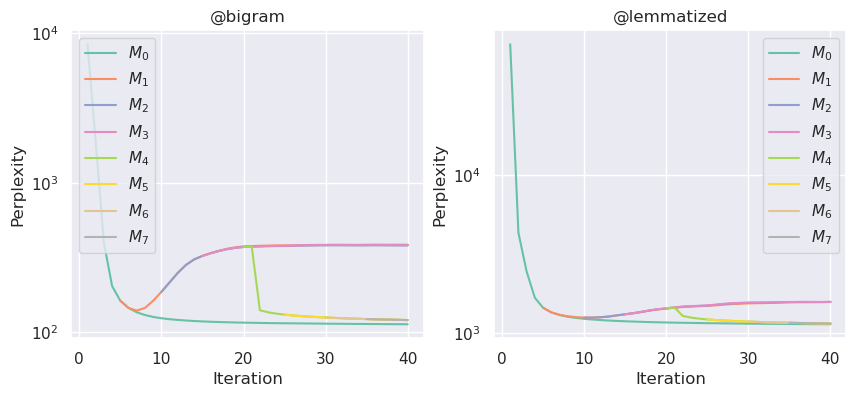

In [46]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["PerplexityScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["PerplexityScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")

_Возможно, здесь можно наблюдать, почему подозрения по поводу слишком быстрого обучения $M_4$ относительно $M_3$, которая по идее должна быть той же самой моделью за исключением `seed`, оказались ненапрасными._ Кроме того, использование регуляризаторов, как и предполагается, способствуют характеризации модели за счёт увеличения перплексии.

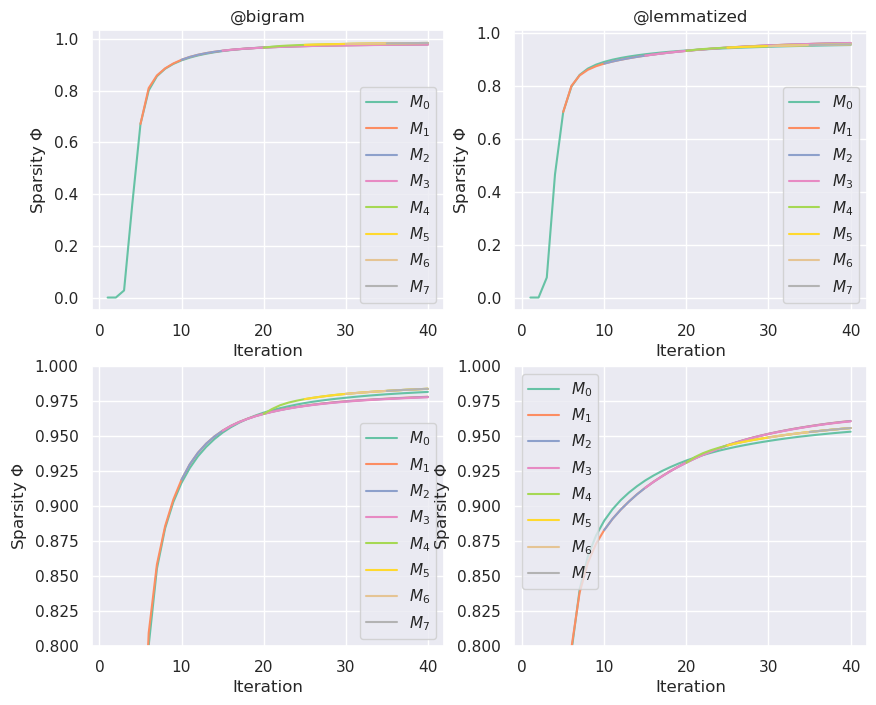

In [54]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 3)
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 4)
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

По модальности `@bigram` модели $M_1$, $M_2$, $M_3$ обладают чуть меньшей разреженностью матрицы $\Phi$, чем $M_4$, $M_5$, $M_6$, $M_7$. Впрочем, по модальности `@lemmatized` наблюдается немного иная ситуация, где наоборот, у моделей $M_1$, $M_2$, $M_3$ достигается более высокая разреженность матрицы $\Phi$.

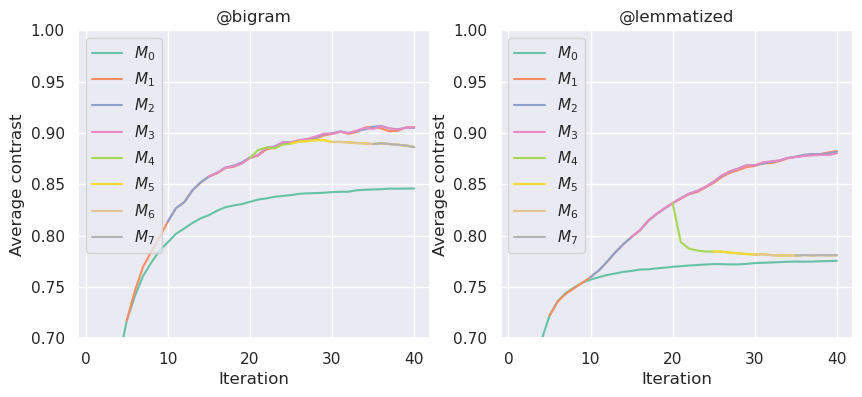

In [63]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["TopicKernel@bigram"].average_contrast[
                (start - 1) :
            ],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.7, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5, tm_6, tm_7],
        ["$M_0$", "$M_1$", "$M_2$", "$M_3$", "$M_4$", "$M_5$", "$M_6$", "$M_7$"],
        [1, 5, 10, 15, 20, 25, 30, 35],
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["TopicKernel@lemmatized"].average_contrast[
                (start - 1) :
            ],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.7, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")

Использование регуляризаторов сглаживания для фиксации релевантных тем и декоррелирования релевантных тем с мусорными _(у моделей $M_1$, $M_2$, $M_3$ настроено, похоже, должным образом, причины, почему изменилось у $M_4$, $M_5$, $M_6$, $M_7$ неизвестны)_ способствует более высокой контрастности тем, что особенно сильно проявляется на модальности `@lemmatized`.

Вот почему не иссследуем среднюю когерентность _(это касается всех моделей)_:

In [59]:
tm_3.score_tracker["TopicKernel@lemmatized"].average_coherence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Смотрим на темы после дообучения $M_3$ до $40$ итераций.

_Возможно, стоило действительно делать каждый по отдельности регуляризатор сглаживания на каждую релевантную тему, а один общий, указывать в качестве `topic_names` список этих тем, и, возможно, при клонировании было бы легче создавать заново и избежать проблем при клонировании, но вообще очень странно, почему они возникают._

In [64]:
cur_model_top_tok = TopTokensViewer(tm_3, num_top_tokens=5, method="phi")
cur_model_top_tok.view_from_jupyter()

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арабский_эмират 
 0.958680 
 
 
 объединить_арабский 
 0.003440 
 
 
 олег_митволя 
 0.003230 
 
 
 забайкальский_край 
 0.001870 
 
 
 росприроднадзор_олег 
 0.001670 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 испания 
 0.026810 
 
 
 испанский 
 0.023300 
 
 
 арабский 
 0.012910 
 
 
 росприроднадзор 
 0.012430 
 
 
 митволя 
 0.011930 
 
 
 
 
 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нобелевский_премия 
 0.889120 
 
 
 гарри_поттер 
 0.007440 
 
 
 егор_титов 
 0.003710 
 
 
 inglorious_bastards 
 0.003370 
 
 
 брэд_питта 
 0.003370 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 картина 
 0.059930 
 
 
 роль 
 0.036750 
 
 
 актёр 
 0.023180 
 
 
 режиссёр 
 0.023130 
 
 
 год 
 0.022550 
 
 
 
 
 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 моральный_ущерб 
 0.963910 
 
 
 компенсация_моральный 
 0.002810 
 
 
 моральный_вред 
 0.002500 
 
 
 возмещение_моральный 
 0.001980 
 
 
 обязать_выплатить 
 0.001950 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.995280 
 
 
 моральный 
 0.000160 
 
 
 ярузельский 
 0.000160 
 
 
 буксман 
 0.000130 
 
 
 карра 
 0.000120 
 
 
 
 
 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 гордон_браун 
 0.888140 
 
 
 бин_ладен 
 0.012250 
 
 
 экономический_санкция 
 0.005900 
 
 
 осама_бин 
 0.004790 
 
 
 махмуд_ахмадинеджад 
 0.004120 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 великобритания 
 0.043550 
 
 
 иран 
 0.033150 
 
 
 ядерный 
 0.015670 
 
 
 иранский 
 0.011940 
 
 
 браун 
 0.011250 
 
 
 
 
 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ролан_гарроса 
 0.045300 
 
 
 ракетка_мир 
 0.036740 
 
 
 мария_шарапов 
 0.026080 
 
 
 елена_дементьев 
 0.023780 
 
 
 теннисный_турнир 
 0.023380 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.020930 
 
 
 первый 
 0.014930 
 
 
 матч 
 0.014400 
 
 
 счёт 
 0.011370 
 
 
 сафин 
 0.011140 
 
 
 
 
 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 york_times 
 0.992750 
 
 
 де_жанейро 
 0.001270 
 
 
 рио_де 
 0.001270 
 
 
 призовой_фонд 
 0.001180 
 
 
 кортни_лав 
 0.000880 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 new 
 0.990710 
 
 
 york 
 0.003260 
 
 
 роналдый 
 0.000240 
 
 
 трансвестит 
 0.000150 
 
 
 жанейро 
 0.000120 
 
 
 
 
 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 принимать_участие 
 0.919470 
 
 
 православный_церковь 
 0.008640 
 
 
 алексий_ii 
 0.005970 
 
 
 архиерейский_собор 
 0.005460 
 
 
 русский_православный 
 0.005090 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 принимать 
 0.982590 
 
 
 диомид 
 0.001200 
 
 
 православный 
 0.000860 
 
 
 рпц 
 0.000820 
 
 
 алексий 
 0.000690 
 
 
 
 
 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_кавказ 
 0.935650 
 
 
 bear_stearns 
 0.004150 
 
 
 исправительный_учреждение 
 0.003410 
 
 
 административный_округ 
 0.003140 
 
 
 экспортный_пошлина 
 0.003080 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 город 
 0.032130 
 
 
 москва 
 0.019920 
 
 
 объект 
 0.013970 
 
 
 сочи 
 0.013480 
 
 
 городской 
 0.012400 
 
 
 
 
 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 норильский_никель 
 0.891810 
 
 
 собрание_акционер 
 0.009720 
 
 
 владимир_потанин 
 0.008590 
 
 
 михаил_прохоров 
 0.008590 
 
 
 олег_дерипаск 
 0.007560 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 директор 
 0.190920 
 
 
 совет 
 0.047240 
 
 
 акционер 
 0.035170 
 
 
 холдинг 
 0.012730 
 
 
 принадлежать 
 0.009910 
 
 
 
 
 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @

Далее строим те же графики, но без учёта $M_4$, $M_5$, $M_6$, $M_7$, где, _возможно_, возникла проблема с регуляризаторами при клонировании, но на это если и есть указания, то только косвенные.

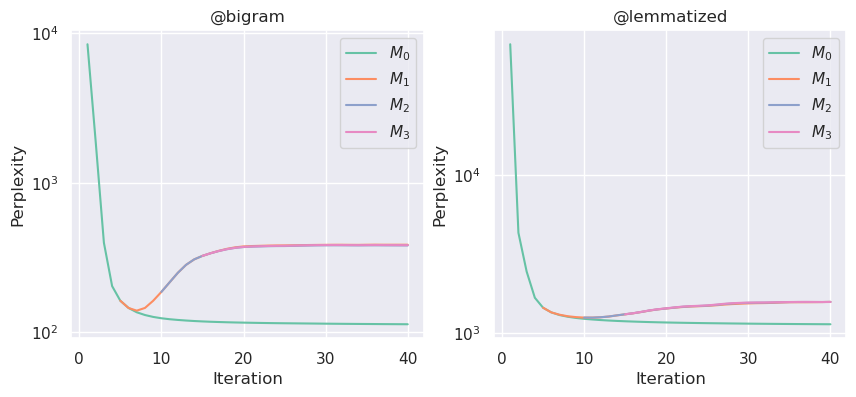

In [65]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["PerplexityScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["PerplexityScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")

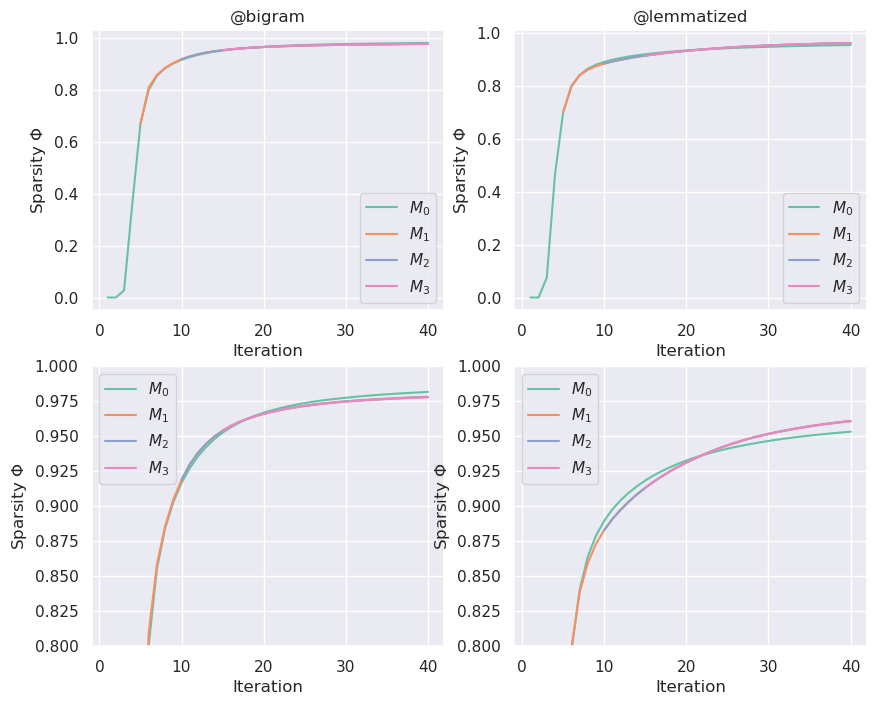

In [66]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 3)
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@bigram"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

    plt.subplot(2, 2, 4)
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["SparsityPhiScore@lemmatized"].value[(start - 1) :],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity $\\Phi$")

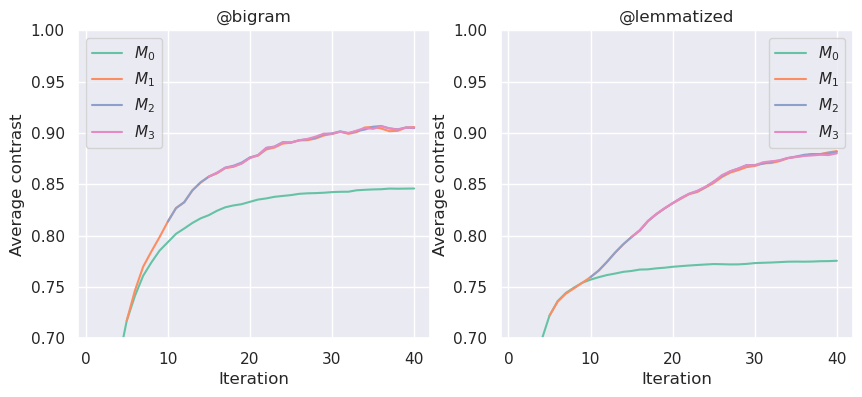

In [67]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("@bigram")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["TopicKernel@bigram"].average_contrast[
                (start - 1) :
            ],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.7, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")

    plt.subplot(1, 2, 2)
    plt.title("@lemmatized")
    for cur_model, model_name, start in zip(
        [tm_0, tm_1, tm_2, tm_3], ["$M_0$", "$M_1$", "$M_2$", "$M_3$"], [1, 5, 10, 15]
    ):
        plt.plot(
            np.arange(start, 41),
            cur_model.score_tracker["TopicKernel@lemmatized"].average_contrast[
                (start - 1) :
            ],
            label=model_name,
        )
    plt.legend()
    plt.ylim(0.7, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Average contrast")